In [44]:
import torch
import torchaudio
import numpy as np
from scipy.signal import medfilt
import matplotlib.pyplot as plt


# def smooth_labels(label_string, window_size=10):
#     label_list = [int(x) for x in label_string]
#     smoothed_list = []
#     for i in range(len(label_list)):
#         start = max(0, i - window_size//2)
#         end = min(len(label_list), i + window_size//2 + 1)
#         smoothed_list.append(int(round(np.mean(label_list[start:end]))))
#     smoothed_string = ''.join([str(x) for x in smoothed_list])
#     return smoothed_string

# median filter
def smooth_labels(label_string, window_size=11):
    label_list = np.array([int(x) for x in label_string])
    smoothed_list = medfilt(label_list, kernel_size=window_size)
    smoothed_string = ''.join([str(x) for x in smoothed_list])
    return smoothed_string

def plot_fbank_with_vad(fbank, vad_str, title=None):

    vad = np.array(list(map(int, vad_str)))
    # Set the figure size using figsize parameter
    fig, ax = plt.subplots(figsize=(10, 8))

    # Visualize the filterbank energies using matplotlib
    im = ax.imshow(fbank.t().numpy(), aspect='auto', origin='lower')
    plt.xlabel('Frame')
    plt.ylabel('Mel filter')

    # Draw markers to indicate segment boundaries
    for i in range(len(vad)):
        if vad[i] != vad[i-1]:
            if vad[i] == 1:
                ax.axvline(x=i, color='red', label='Start 0-1')
            else:
                ax.axvline(x=i-1, color='blue', label='End 1-0')
    
    # Set the title if provided
    if title is not None:
        plt.title(title)

    plt.legend()
    plt.colorbar(im)
    plt.show()

def fbank_based_vad(fbank_feats, num_mel_bins, percent):
    """
    Detects voice activity in a waveform using a filterbank-based VAD.

    Args:
        waveform (torch.Tensor): A 1D Tensor representing a waveform.
        num_mel_bins (int): The number of Mel filterbank channels.
        percent (int): The percentile of frame energies to use as the threshold.

    Returns:
        torch.Tensor: A 1D Tensor representing the voice activity detection.
    """

    # Compute energy per frame
    frame_energy = torch.sum(fbank_feats, dim=1)

    # Compute energy per frame
    # _fbank_feats =  fbank_feats + 15.9424
    # frame_energy = torch.sum(_fbank_feats ** 2, dim=1)

    # Compute threshold as the 30th percentile of frame energies
    threshold = torch.tensor(np.percentile(frame_energy.numpy(), percent))

    # Detect voice activity by thresholding frame energies
    vad = torch.where(frame_energy > threshold, torch.ones_like(frame_energy), torch.zeros_like(frame_energy))

    return vad


def compare(filename):
    # Load waveform from file
    waveform, sample_rate = torchaudio.load(filename)

    # normalize waveform
    waveform = waveform / torch.max(torch.abs(waveform))

    # Compute fbank features
    fbank_feats = torchaudio.compliance.kaldi.fbank(waveform, htk_compat=True, num_mel_bins=num_mel_bins)


    vad = fbank_based_vad(fbank_feats, num_mel_bins=128, percent=50)


    vad_str = ''.join([str(int(vad)) for vad in vad])
    smoothed_vad_str = smooth_labels(vad_str)

    print('Vad frame string before smoothing:'+vad_str)
    print('Vad frame string after smoothing:'+smoothed_vad_str)

    plot_fbank_with_vad(fbank_feats, vad_str, 'before smoothing')
    plot_fbank_with_vad(fbank_feats, smoothed_vad_str, 'after smoothing')

Vad frame string before smoothing:0000000000000000000000000011011111111111111111111111111111111111111111111111111111111111111111110000000000000000111111111111111111111111111111111111111111111100000000000000000000000100000000000000000000000000000000000000000000000000
Vad frame string after smoothing:0000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111110000000000000000111111111111111111111111111111111111111111111100000000000000000000000000000000000000000000000000000000000000000000000000


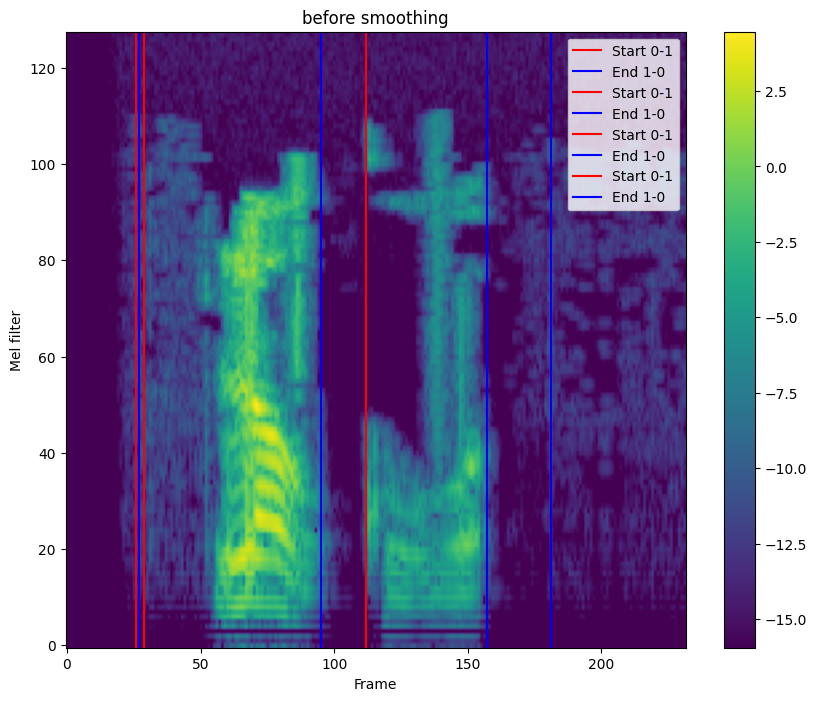

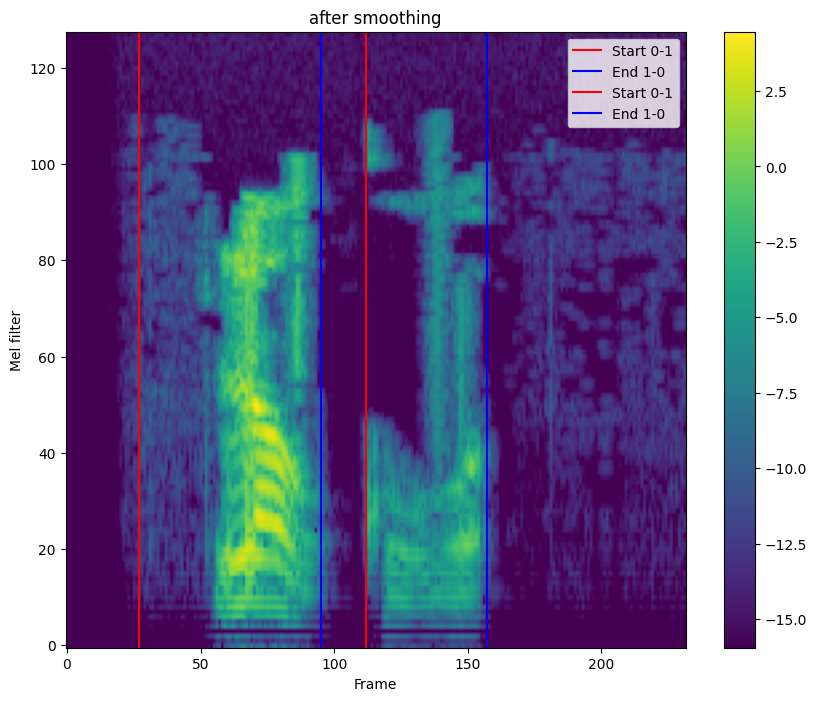

In [46]:
compare(filename="./data/acupoint/data/2000.wav")

Vad frame string before smoothing:00000000000000000000000000000000000011111111111111111111111111111111111111111111100000000001111111000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111011111000000000100000010000011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
Vad frame string after smoothing:00000000000000000000000000000000000011111111111111111111111111111111111111111111100000000001111111000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


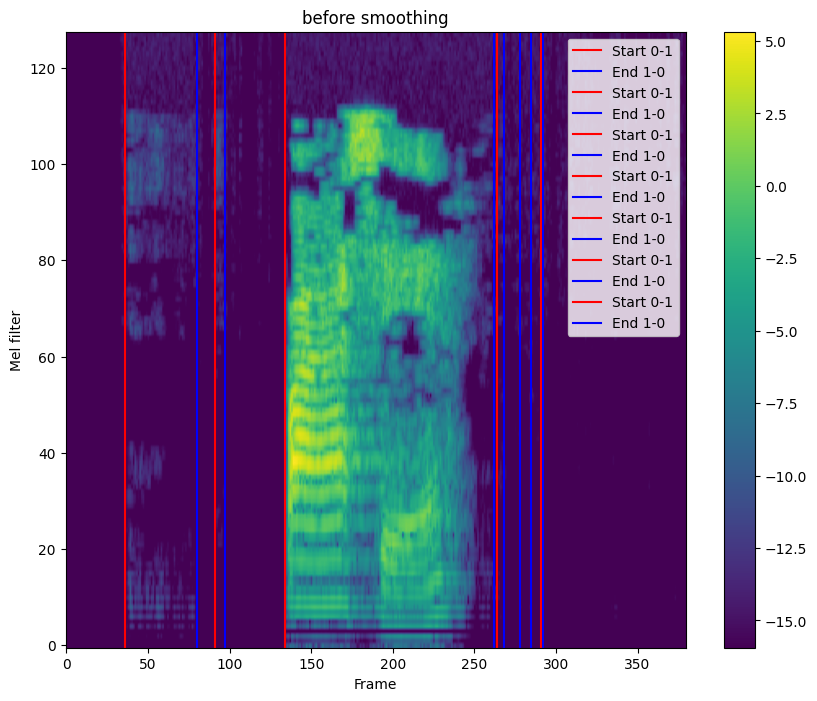

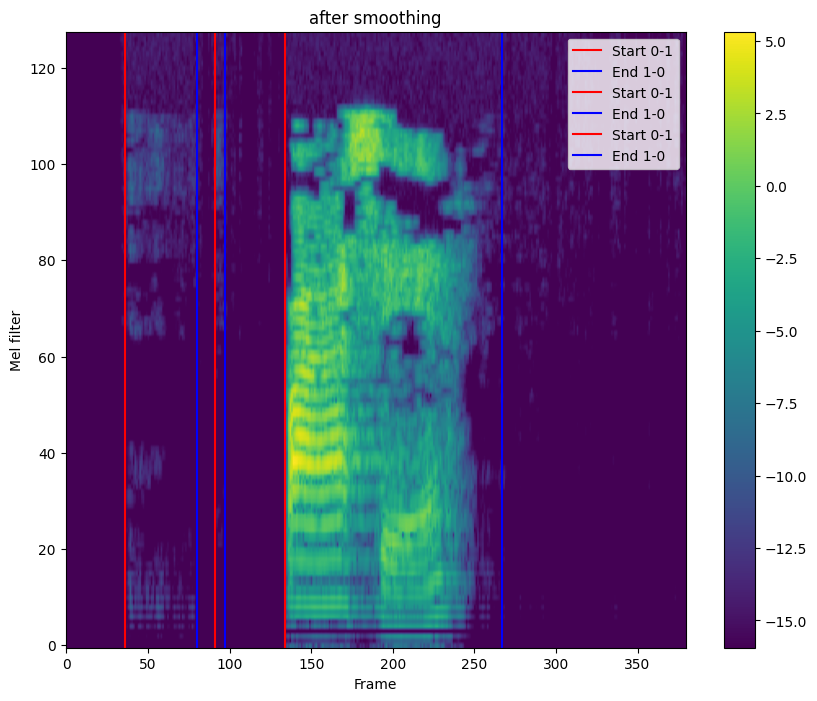

In [47]:
compare(filename="./data/acupoint/data/4900.wav")

Vad frame string before smoothing:00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111100111111111111111111111111111111111111111111111111111000
Vad frame string after smoothing:00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000


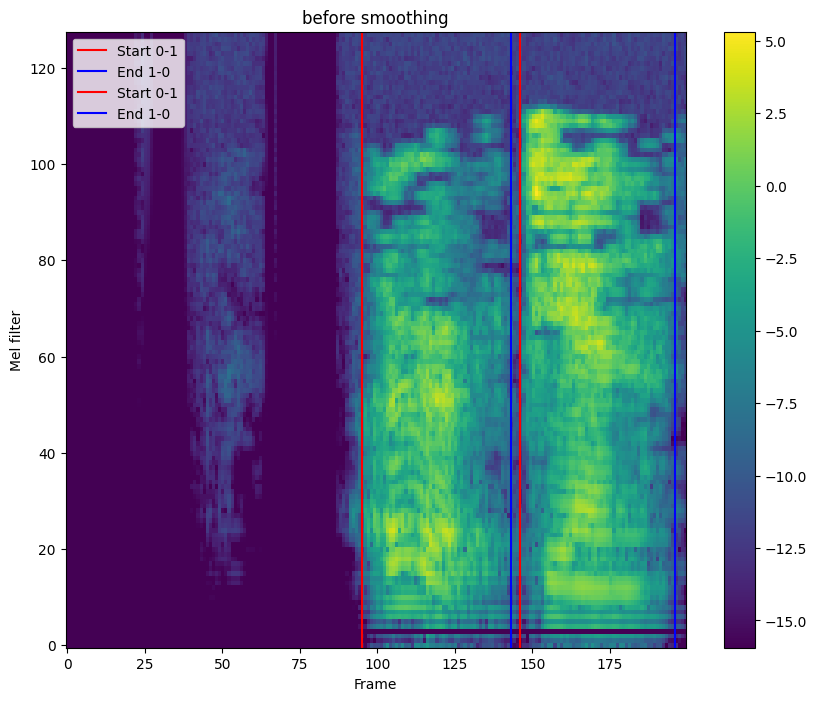

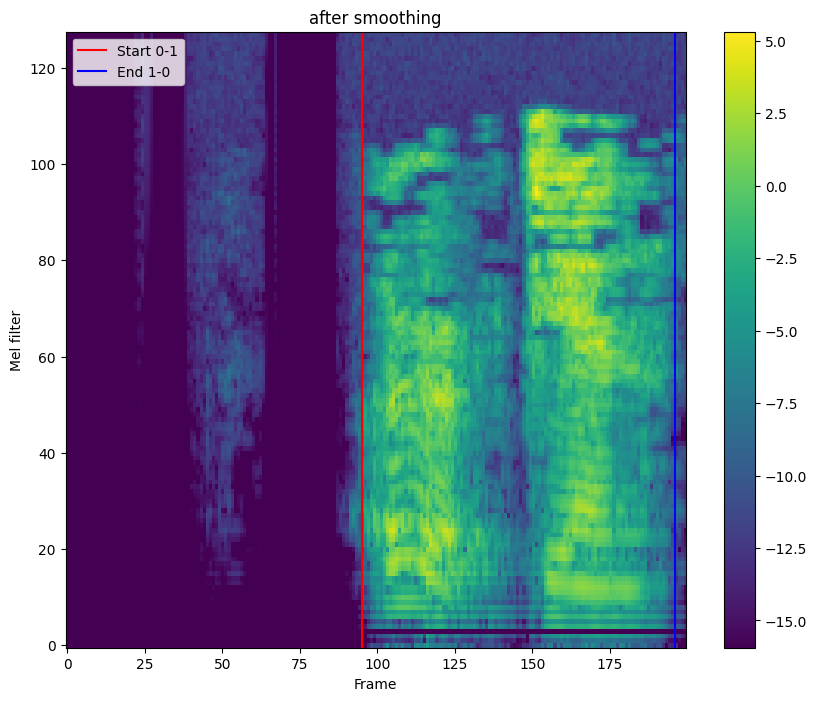

In [48]:
compare(filename="./data/acupoint/data/3452.wav")

Vad frame string before smoothing:00000000000000000000000001111111100000000000000000000000011111111111111111111111111110000000001111111111111111111111111111111111111111111111100000000000000000000000000
Vad frame string after smoothing:00000000000000000000000001111111100000000000000000000000011111111111111111111111111110000000001111111111111111111111111111111111111111111111100000000000000000000000000


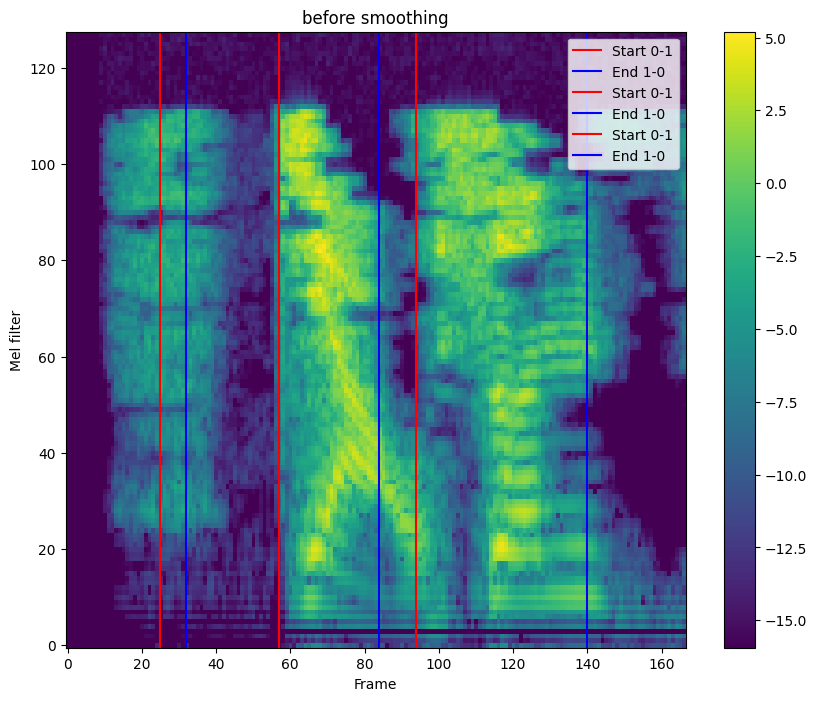

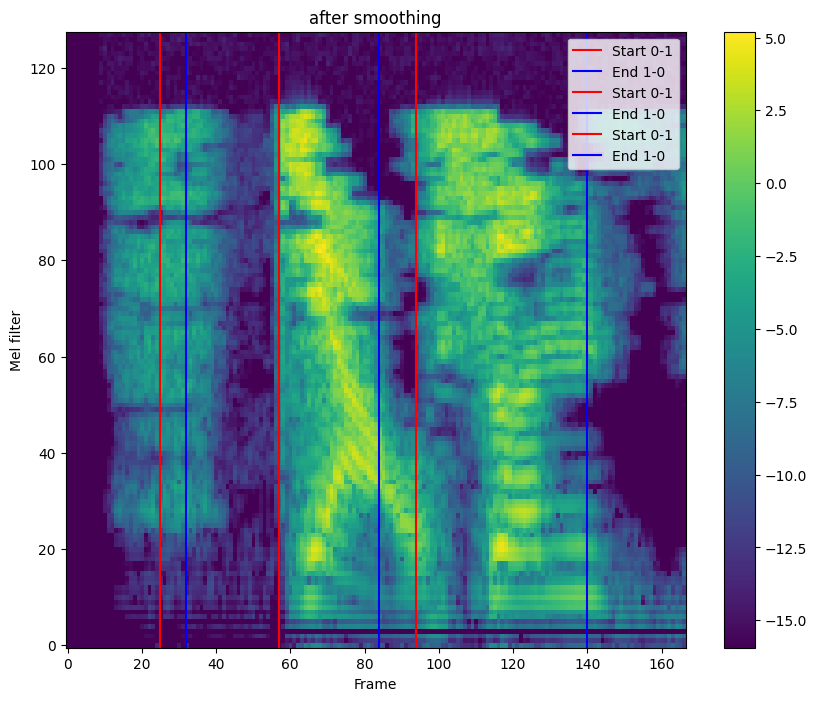

In [49]:
compare(filename="./data/acupoint/data/4780.wav")